In [2]:
!pip install transformers
!pip install timm
!pip install deeplake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.5/574.5 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 4

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
import timm

In [4]:
from dataprocessing import DataLoaderWrapper

data=DataLoaderWrapper(batch_size=32, image_size=224)
#celebA_train,celebA_val,celebA_test=data.initialize_celebA_dataloaders()
adience=data.initialize_adience_dataloaders()

\

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/adience



-

hub://activeloop/adience loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-train



\

hub://activeloop/celeb-a-train loaded successfully.



-

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-val



\

hub://activeloop/celeb-a-val loaded successfully.



|

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-test



\

hub://activeloop/celeb-a-test loaded successfully.



/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [5]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

#model.eval()  # Set the model to evaluation mode
'''
# Prepare to collect the predictions
all_probabilities = []

with torch.no_grad():
    for test_images, age_labels, gender_labels in celebA_val:
        out = model(test_images)

        # Apply softmax to calculate probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Collect the probabilities for further processing or analysis
        all_probabilities.append(probabilities)

#probabilities = torch.nn.functional.softmax(out[0], dim=0)
'''

'\n# Prepare to collect the predictions\nall_probabilities = []\n\nwith torch.no_grad():\n    for test_images, age_labels, gender_labels in celebA_val:\n        out = model(test_images)\n\n        # Apply softmax to calculate probabilities\n        probabilities = torch.nn.functional.softmax(outputs, dim=1)\n\n        # Collect the probabilities for further processing or analysis\n        all_probabilities.append(probabilities)\n\n#probabilities = torch.nn.functional.softmax(out[0], dim=0)\n'

In [6]:
num_classes = 4  # 2 classes: male and female
model.head = nn.Linear(model.head.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [7]:
'''
for batch in adience:
    print(batch)
    break  # Just print the first batch to see what's inside
'''

"\nfor batch in adience:\n    print(batch)\n    break  # Just print the first batch to see what's inside\n"

In [8]:
# Make sure the model is in evaluation mode
model.eval()

# Trackers
total_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient calculation
    for batch in adience:
        images = batch['images'].to(device)
        labels = batch['genders'].to(device)

        # Adjust labels if they are one-hot encoded
        if len(labels.size()) > 1:
            labels = torch.argmax(labels, dim=1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate average loss and accuracy
avg_loss = total_loss / len(adience)
accuracy = correct_predictions / total_predictions

print(f'Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Average Loss: 0.7531, Accuracy: 0.7628


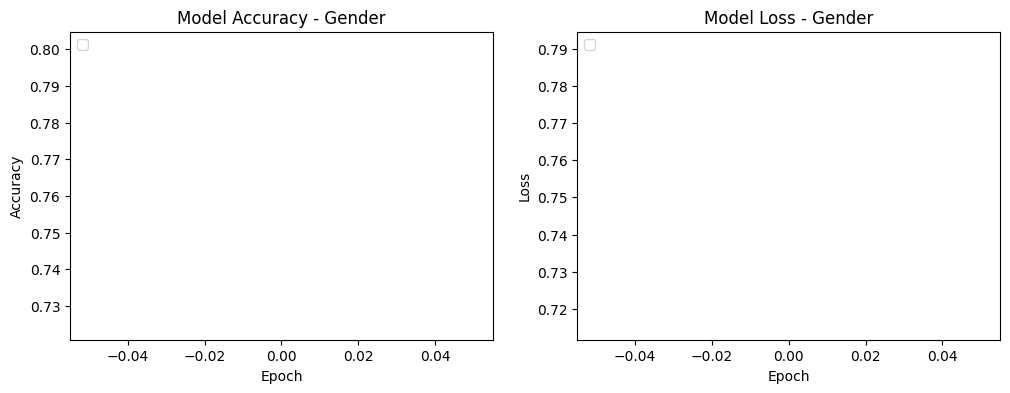

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy)
#plt.plot(val_accuracies, label='Validation')
plt.title('Model Accuracy - Gender')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(avg_loss)
#plt.plot(val_losses, label='Validation')
plt.title('Model Loss - Gender')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

## Age Classification

In [10]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_classes = 8  # 8 different age groups
model.head = nn.Linear(model.head.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [12]:
# Make sure the model is in evaluation mode
model.eval()

# Trackers
total_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient calculation
    for batch in adience:
        images = batch['images'].to(device)
        labels = batch['ages'].to(device)

        # Adjust labels if they are one-hot encoded
        if len(labels.size()) > 1:
            labels = torch.argmax(labels, dim=1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate average loss and accuracy
avg_loss = total_loss / len(adience)
accuracy = correct_predictions / total_predictions

print(f'Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Average Loss: 2.9813, Accuracy: 0.0379


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy)
#plt.plot(val_accuracies, label='Validation')
plt.title('Model Accuracy - Age')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(avg_loss)
#plt.plot(val_losses, label='Validation')
plt.title('Model Loss - Age')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()